In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot

In [2]:
def ConvertEventToNumpy(dfs, event):
    data = np.zeros(16)
    for i in range(16):
        if i in dfs:
            data[i] = dfs[i].loc[event]["amplitude"]
    data.shape = (4,4)
    return data

In [3]:
def GetAmplitudeSeedPixel(dfs, event):
    maxAmplitude = 0
    maxPixel = -1
    for i in range(16):
        if i in dfs:
            amplitude = dfs[i].loc[event]["amplitude"]
            if amplitude > maxAmplitude:
                maxAmplitude = amplitude
                maxPixel = i
    return maxPixel, maxAmplitude

In [16]:
df = uproot.open("../Data/run175174828_230428174901_preprocessed.root")["PreprocessedData"]
nPixels = 16
dfs = {}

for i in range(nPixels):
    dfs[i] = df[f"pixel{i}"].arrays(library="pd")
dfs

{0:        pixel  samplingPeriod    baseline  minLevel  t10  t90  t50  fallTime  \
 0          0          250000  238.437040  235.7628 -2.0 -2.0 -2.0      -2.0   
 1          0          250000  238.624301  236.3724 -2.0 -2.0 -2.0      -2.0   
 2          0          250000  238.652876  235.6485 -2.0 -2.0 -2.0      -2.0   
 3          0          250000  238.822230  236.6391 -2.0 -2.0 -2.0      -2.0   
 4          0          250000  238.765271  236.4105 -2.0 -2.0 -2.0      -2.0   
 ...      ...             ...         ...       ...  ...  ...  ...       ...   
 47095      0          250000  236.597001  234.5055 -2.0 -2.0 -2.0      -2.0   
 47096      0          250000  236.844650  233.4768 -2.0 -2.0 -2.0      -2.0   
 47097      0          250000  237.436534  234.6960 -2.0 -2.0 -2.0      -2.0   
 47098      0          250000  236.758353  234.3150 -2.0 -2.0 -2.0      -2.0   
 47099      0          250000  237.121256  234.2007 -2.0 -2.0 -2.0      -2.0   
 
        amplitude  electrons       

<Axes: ylabel='Frequency'>

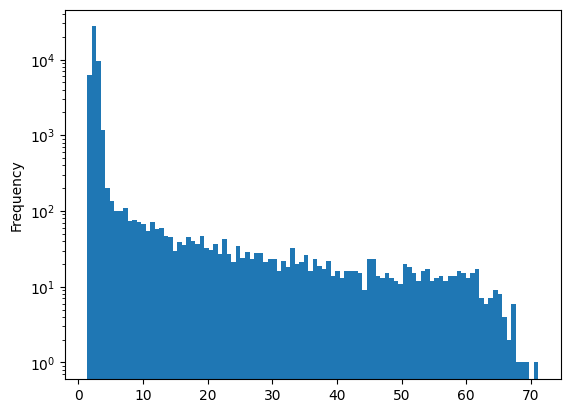

In [17]:
plt.yscale('log')
dfs[1]["amplitude"].plot.hist(bins=100)


In [18]:
dfs[1]["amplitude"]

0        2.843022
1        2.402206
2        2.398394
3        6.152770
4        3.302127
           ...   
47095    2.532317
47096    2.231327
47097    3.236787
47098    2.550985
47099    2.199703
Name: amplitude, Length: 47100, dtype: float64

In [19]:
for i in range(15):
    print(dfs[i].loc[0]["amplitude"])

2.6742402585166474
2.8430221422477473
2.5317456418019617
2.5991820360655993
3.271266608296429
-1.0
50.500384288967034
2.485834568046016
2.844355184901218
-1.0
6.986397867790053
2.200465215759408
2.133600100130394
12.324586910115215
2.7578696301196146


(6, 50.500384288967034)
(9, 24.79298058797899)


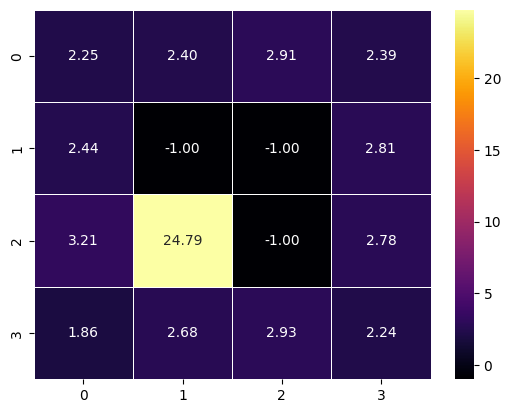

In [20]:
# Create a heatmap of the data
count = 0
for i in range(len(dfs[0])):
    print(GetAmplitudeSeedPixel(dfs, i))
    if GetAmplitudeSeedPixel(dfs, i)[1] > 20:
        if count == 1:
            Event = ConvertEventToNumpy(dfs, i)
            sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno")
            break
        else:
            count += 1

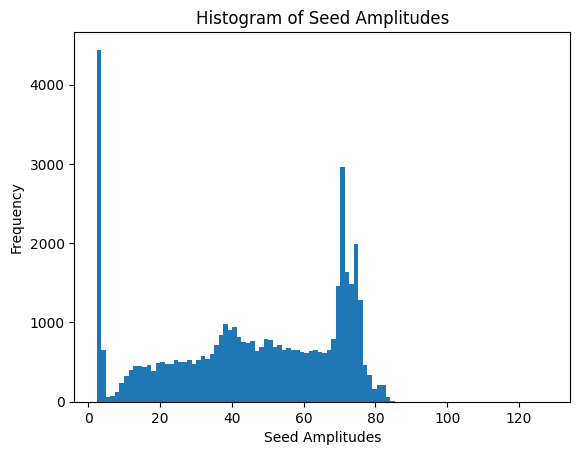

In [21]:
SeedAmplitudes = []
for i in range(len(dfs[0])):
    SeedAmplitudes.append(GetAmplitudeSeedPixel(dfs, i)[1])
plt.hist(SeedAmplitudes, bins=100)
plt.xlabel('Seed Amplitudes')
plt.ylabel('Frequency')
plt.title('Histogram of Seed Amplitudes')
plt.show()


In [10]:
df2 = uproot.open("../Data/run175174828_230428174901_TTree.root")["treeParams"].arrays(library="pd")
df2

/Users/giogi/.pyenv/versions/3.10.8/envs/env1/lib/python3.10/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/Users/giogi/.pyenv/versions/3.10.8/envs/env1/lib/python3.10/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/Users/giogi/.pyenv/versions/3.10.8/envs/env1/lib/python3.10/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  

,Event,Timestamp,BaselinePx0,MinLevelPx0,SignalAmplPx0,t10Px0,t50Px0,t90Px0,FallTimePx0,BaselinePx1,...,t50Px14,t90Px14,FallTimePx14,BaselinePx15,MinLevelPx15,SignalAmplPx15,t10Px15,t50Px15,t90Px15,FallTimePx15
0,0,4096,237.8202,235.7628,2.0574,-999.0,-999.0,-999.0,-999.0,245.6307,...,-999.0,-999.0,-999.0,271.0053,265.4427,5.5626,-999.0,-999.0,-999.0,-999.0
1,1,4096,239.6871,236.3724,3.3147,-999.0,-999.0,-999.0,-999.0,247.6119,...,-999.0,-999.0,-999.0,268.8336,266.0904,2.7432,-999.0,-999.0,-999.0,-999.0
2,2,4096,238.5822,235.6485,2.9337,-999.0,-999.0,-999.0,-999.0,246.1641,...,-999.0,-999.0,-999.0,267.9192,264.8712,3.0480,-999.0,-999.0,-999.0,-999.0
3,3,4096,237.4773,-999.0000,-999.0000,-999.0,-999.0,-999.0,-999.0,247.1166,...,-999.0,-999.0,-999.0,268.3383,266.0904,2.2479,-999.0,-999.0,-999.0,-999.0
4,4,4096,238.8108,236.4105,2.4003,-999.0,-999.0,-999.0,-999.0,246.4308,...,-999.0,-999.0,-999.0,267.7287,265.7856,1.9431,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47096,47096,4096,236.0295,233.4768,2.5527,-999.0,-999.0,-999.0,-999.0,246.4308,...,-999.0,-999.0,-999.0,266.4714,264.1854,2.2860,-999.0,-999.0,-999.0,-999.0
47097,47097,4096,236.2962,234.6960,1.6002,-999.0,-999.0,-999.0,-999.0,245.2878,...,-999.0,-999.0,-999.0,267.3477,264.3378,3.0099,-999.0,-999.0,-999.0,-999.0
47098,47098,4096,235.5342,234.3150,1.2192,-999.0,-999.0,-999.0,-999.0,245.8974,...,-999.0,-999.0,-999.0,266.5095,264.7188,1.7907,-999.0,-999.0,-999.0,-999.0
47099,47099,4096,236.1057,234.2007,1.9050,-999.0,-999.0,-999.0,-999.0,244.5639,...,-999.0,-999.0,-999.0,267.1953,264.3378,2.8575,-999.0,-999.0,-999.0,-999.0


In [11]:
dfs2 = {}
for i in range(nPixels):
    dfs2[i] = df2.filter(like=f'Px{i}').rename(columns = {f"SignalAmpPx{i}": "amplitude"})
    dfs2[i] = dfs2[i].rename(columns = {f"SignalAmplPx{i}": "amplitude"})
dfs2[0]

dfb2 = {}
for i in range(nPixels):
    dfb2[i] = df2.filter(like=f'Px{i}').rename(columns = {f"BaselinePx{i}": "baseline"})
    dfb2[i] = dfb2[i].rename(columns = {f"BaselinePx{i}": "baseline"})
dfb2[0]


,baseline,MinLevelPx0,SignalAmplPx0,t10Px0,t50Px0,t90Px0,FallTimePx0
0,237.8202,235.7628,2.0574,-999.0,-999.0,-999.0,-999.0
1,239.6871,236.3724,3.3147,-999.0,-999.0,-999.0,-999.0
2,238.5822,235.6485,2.9337,-999.0,-999.0,-999.0,-999.0
3,237.4773,-999.0000,-999.0000,-999.0,-999.0,-999.0,-999.0
4,238.8108,236.4105,2.4003,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...
47096,236.0295,233.4768,2.5527,-999.0,-999.0,-999.0,-999.0
47097,236.2962,234.6960,1.6002,-999.0,-999.0,-999.0,-999.0
47098,235.5342,234.3150,1.2192,-999.0,-999.0,-999.0,-999.0
47099,236.1057,234.2007,1.9050,-999.0,-999.0,-999.0,-999.0


In [12]:
dfs[0]

,pixel,samplingPeriod,baseline,minLevel,t10,t90,t50,fallTime,amplitude,electrons,RMS
0,0,250000,238.437040,235.7628,-2.0,-2.0,-2.0,-2.0,2.674240,inf,1.151204
1,0,250000,238.624301,236.3724,-2.0,-2.0,-2.0,-2.0,2.251901,inf,1.030138
2,0,250000,238.652876,235.6485,-2.0,-2.0,-2.0,-2.0,3.004376,inf,1.090737
3,0,250000,238.822230,236.6391,-2.0,-2.0,-2.0,-2.0,2.183130,inf,1.075007
4,0,250000,238.765271,236.4105,-2.0,-2.0,-2.0,-2.0,2.354771,inf,1.116205
...,...,...,...,...,...,...,...,...,...,...,...
47095,0,250000,236.597001,234.5055,-2.0,-2.0,-2.0,-2.0,2.091501,inf,0.934715
47096,0,250000,236.844650,233.4768,-2.0,-2.0,-2.0,-2.0,3.367850,inf,1.020630
47097,0,250000,237.436534,234.6960,-2.0,-2.0,-2.0,-2.0,2.740534,inf,1.150052
47098,0,250000,236.758353,234.3150,-2.0,-2.0,-2.0,-2.0,2.443353,inf,0.776471


(6, 23.17448331461005)
(9, 11.186289252352374)
(6, 32.08557266784481)


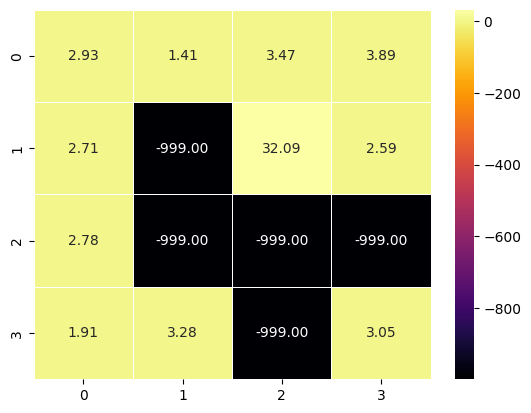

In [13]:
# Create a heatmap of the data
count = 0
for i in range(len(dfs2[0])):
    print(GetAmplitudeSeedPixel(dfs2, i))
    if GetAmplitudeSeedPixel(dfs2, i)[1] > 20:
        if count == 1:
            Event = ConvertEventToNumpy(dfs2, i)
            sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno")
            break
        else:
            count += 1

<Axes: >

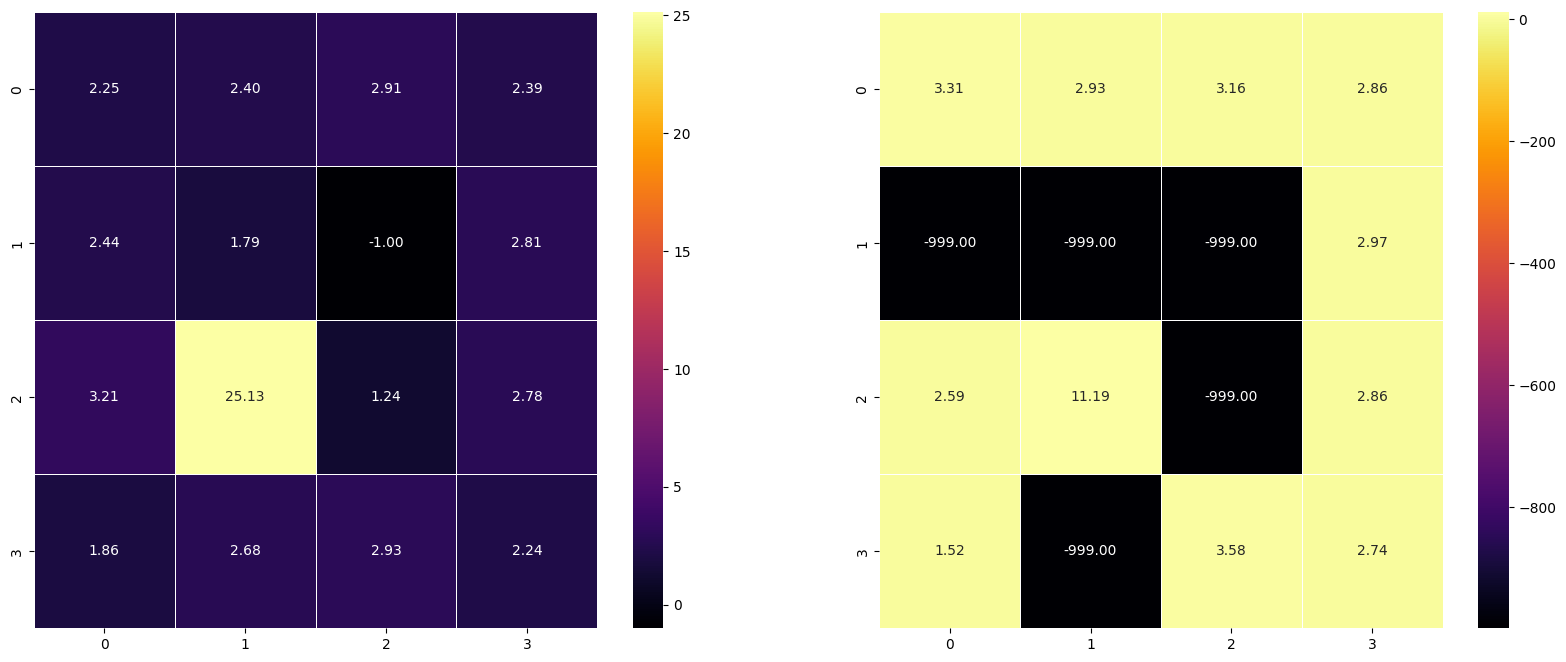

In [14]:
fig, axs = plt.subplots(1,2, figsize=(20,8))
EvN = 1
Event = ConvertEventToNumpy(dfs, EvN)
sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno", ax=axs[0])
Event = ConvertEventToNumpy(dfs2, EvN)
sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno", ax=axs[1])

In [15]:
print("Gruppo 1")
for i in range(16): print(dfs[i].loc[0]["baseline"])
print("Prino/Aglietta")
for i in range(16): print(dfb2[i].loc[0]["baseline"])


Gruppo 1
238.43704025851665
246.68302214224775
236.04664564180197
253.48768203606562
237.62436660829644
50.800919239336736
49.119694105001386
222.81813456804602
226.30085518490122
47.95466738134127
50.11138612387551
238.8014652157594
217.8939001001304
246.7157869101152
243.05456963011963
267.7856598048774
Prino/Aglietta
237.82020002341358
245.6306999947132
237.43920004870088
253.4411999512409
238.08690009298843
50.611716567692284
21.999815292649554
222.77070001770696
226.39020008456112
47.77156546019673
46.18543088016418
239.72519995380506
218.38920009085075
248.37389996081328
244.18290007961374
271.0052999833302
